In [5]:
# --- 1. IMPORTS AND SETUP ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import classification_report, f1_score
from sklearn.utils import class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import warnings

warnings.filterwarnings('ignore')
# Download stopwords if you haven't already
try:
    stopwords.words('english')
except LookupError:
    nltk.download('stopwords')

print("✅ Libraries imported successfully.")

✅ Libraries imported successfully.



✅ Dataset loaded successfully.

📊 Performing Exploratory Data Analysis (EDA)...


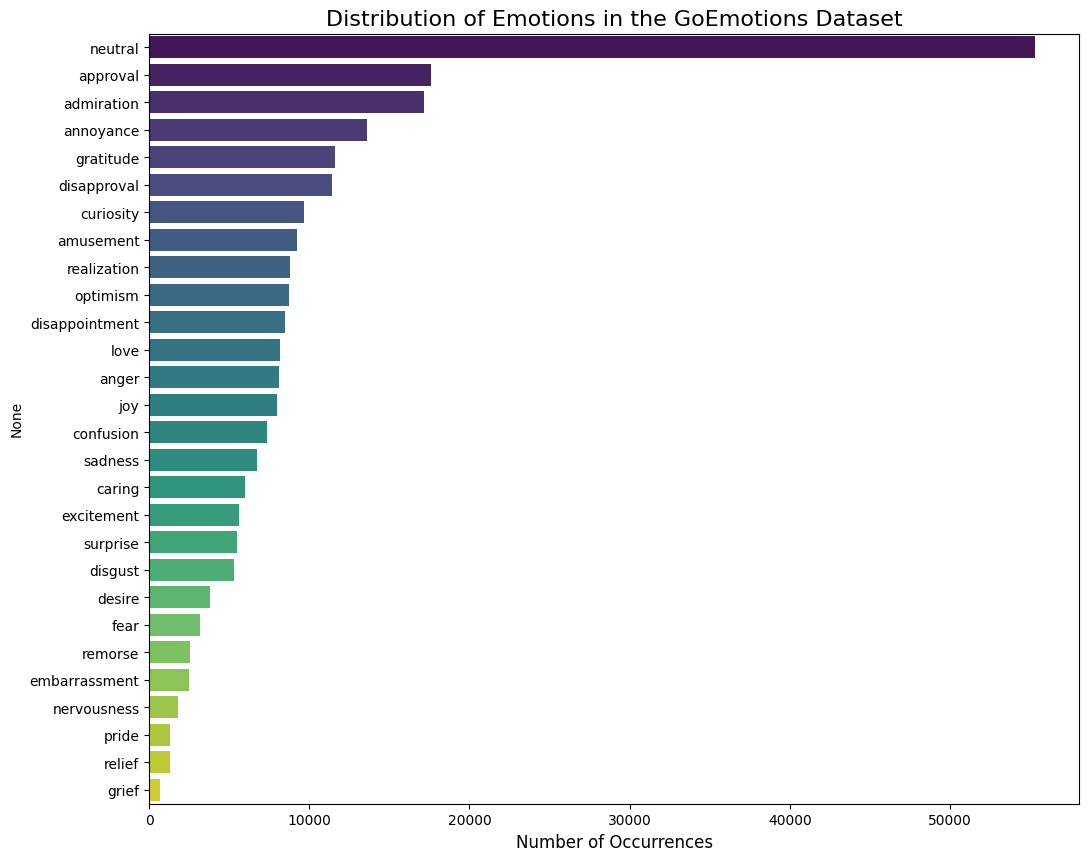

In [8]:
# --- 2. LOAD DATA AND EDA ---
try:
    df = pd.read_csv('GoEmotions.csv')
    print("\n✅ Dataset loaded successfully.")
except FileNotFoundError:
    print("❌ Error: GoEmotions.csv not found. Please upload the dataset.")
    exit()

emotion_cols = ['admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion',
                'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust', 'embarrassment',
                'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism',
                'pride', 'realization', 'relief', 'remorse', 'sadness', 'surprise', 'neutral']

print("\n📊 Performing Exploratory Data Analysis (EDA)...")
emotion_counts = df[emotion_cols].sum().sort_values(ascending=False)
plt.figure(figsize=(12, 10))
sns.barplot(x=emotion_counts.values, y=emotion_counts.index, palette='viridis')
plt.title('Distribution of Emotions in the GoEmotions Dataset', fontsize=16)
plt.xlabel('Number of Occurrences', fontsize=12)
plt.show()

In [9]:
# --- 3. TEXT PREPROCESSING ---
print("\n🔄 Preprocessing text data...")
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    text = ' '.join(word for word in text.split() if word not in stop_words)
    return text

df['text_cleaned'] = df['text'].apply(preprocess_text)
print("✅ Text cleaning complete.")


🔄 Preprocessing text data...
✅ Text cleaning complete.


In [10]:
# --- 4. DATA PREPARATION FOR MODELS ---
X_text = df['text_cleaned']
y = df[emotion_cols]

# Using a smaller sample for faster demonstration. Increase for final results.
df_sample = df.sample(n=50000, random_state=42)
X_sample = df_sample['text_cleaned']
y_sample = df_sample[emotion_cols]

X_train, X_test, y_train, y_test = train_test_split(X_sample, y_sample, test_size=0.2, random_state=42)

print("\n✅ Data prepared for modeling:")
print(f" - Training set size: {len(X_train)}")
print(f" - Test set size: {len(X_test)}")

# Vectorize the text data using TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)


✅ Data prepared for modeling:
 - Training set size: 40000
 - Test set size: 10000


In [13]:
# --- 5. MODEL 1: LOGISTIC REGRESSION (WITH CLASS WEIGHTS) ---
print("\n\n--- Training Model 1: Logistic Regression (Balanced) ---")
# Using class_weight='balanced' tells the model to penalize mistakes on minority classes more heavily.
log_reg = LogisticRegression(solver='liblinear', random_state=42, class_weight='balanced')
ovr_log_reg = MultiOutputClassifier(log_reg)

print("🚀 Fitting the model...")
ovr_log_reg.fit(X_train_tfidf, y_train)

y_pred_log_reg = ovr_log_reg.predict(X_test_tfidf)
print("\n📊 Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_log_reg, target_names=emotion_cols, zero_division=0))



--- Training Model 1: Logistic Regression (Balanced) ---
🚀 Fitting the model...

📊 Logistic Regression Classification Report:
                precision    recall  f1-score   support

    admiration       0.33      0.68      0.44       821
     amusement       0.39      0.74      0.51       447
         anger       0.16      0.58      0.25       405
     annoyance       0.14      0.51      0.23       671
      approval       0.13      0.44      0.20       804
        caring       0.11      0.56      0.18       269
     confusion       0.08      0.41      0.13       341
     curiosity       0.10      0.45      0.16       451
        desire       0.10      0.47      0.17       188
disappointment       0.10      0.44      0.17       423
   disapproval       0.11      0.48      0.18       563
       disgust       0.11      0.50      0.18       244
 embarrassment       0.05      0.34      0.09       112
    excitement       0.09      0.48      0.16       264
          fear       0.18      

In [14]:
# --- 6. MODEL 2: RANDOM FOREST (WITH CLASS WEIGHTS) ---
print("\n\n--- Training Model 2: Random Forest (Balanced) ---")
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, class_weight='balanced')
ovr_rf = MultiOutputClassifier(rf_classifier)

print("🚀 Fitting the model...")
ovr_rf.fit(X_train_tfidf, y_train)

y_pred_rf = ovr_rf.predict(X_test_tfidf)
print("\n📊 Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf, target_names=emotion_cols, zero_division=0))



--- Training Model 2: Random Forest (Balanced) ---
🚀 Fitting the model...

📊 Random Forest Classification Report:
                precision    recall  f1-score   support

    admiration       0.48      0.42      0.45       821
     amusement       0.47      0.49      0.48       447
         anger       0.30      0.25      0.27       405
     annoyance       0.20      0.13      0.16       671
      approval       0.21      0.14      0.17       804
        caring       0.20      0.14      0.17       269
     confusion       0.12      0.16      0.14       341
     curiosity       0.16      0.20      0.18       451
        desire       0.28      0.17      0.21       188
disappointment       0.18      0.10      0.13       423
   disapproval       0.16      0.15      0.16       563
       disgust       0.20      0.17      0.19       244
 embarrassment       0.17      0.12      0.15       112
    excitement       0.15      0.14      0.15       264
          fear       0.27      0.23      0.

In [15]:
# --- 7. MODEL 3: TUNED RANDOM FOREST (BALANCED) ---
print("\n\n--- Training Model 3: Tuned Random Forest (Balanced) ---")
rf_tuned = RandomForestClassifier(
    n_estimators=100,
    min_samples_leaf=2,
    max_depth=10, # The most important parameter from your search
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'
)
ovr_rf_tuned = MultiOutputClassifier(rf_tuned)

print("🚀 Fitting the tuned model...")
ovr_rf_tuned.fit(X_train_tfidf, y_train)
y_pred_rf_tuned = ovr_rf_tuned.predict(X_test_tfidf)
print("\n📊 Tuned Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf_tuned, target_names=emotion_cols, zero_division=0))



--- Training Model 3: Tuned Random Forest (Balanced) ---
🚀 Fitting the tuned model...

📊 Tuned Random Forest Classification Report:
                precision    recall  f1-score   support

    admiration       0.34      0.64      0.44       821
     amusement       0.48      0.70      0.57       447
         anger       0.20      0.47      0.28       405
     annoyance       0.17      0.42      0.25       671
      approval       0.17      0.31      0.22       804
        caring       0.09      0.43      0.15       269
     confusion       0.11      0.37      0.16       341
     curiosity       0.10      0.34      0.16       451
        desire       0.11      0.42      0.17       188
disappointment       0.11      0.35      0.17       423
   disapproval       0.11      0.40      0.17       563
       disgust       0.15      0.49      0.24       244
 embarrassment       0.08      0.31      0.13       112
    excitement       0.10      0.38      0.16       264
          fear       0.25

In [11]:
# --- 8. MODEL 4: ARTIFICIAL NEURAL NETWORK (ANN) ---
# ANN doesn't have a simple 'balanced' parameter, so we don't apply weights here for simplicity.
# A more advanced implementation could calculate and apply weights manually.
print("\n\n--- Training Model 4: Artificial Neural Network (ANN) ---")
ann_model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_tfidf.shape[1],)),
    Dense(64, activation='relu'),
    Dense(len(emotion_cols), activation='sigmoid')
])
ann_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

print("🚀 Fitting the model...")
ann_model.fit(X_train_tfidf.toarray(), y_train, epochs=5, batch_size=32, verbose=0) # verbose=0 for cleaner output

y_pred_ann_proba = ann_model.predict(X_test_tfidf.toarray())
y_pred_ann = (y_pred_ann_proba > 0.5).astype(int)
print("\n📊 ANN Classification Report:")
print(classification_report(y_test, y_pred_ann, target_names=emotion_cols, zero_division=0))



--- Training Model 4: Artificial Neural Network (ANN) ---
🚀 Fitting the model...
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

📊 ANN Classification Report:
                precision    recall  f1-score   support

    admiration       0.52      0.42      0.46       821
     amusement       0.51      0.38      0.44       447
         anger       0.48      0.14      0.22       405
     annoyance       0.27      0.04      0.07       671
      approval       0.34      0.06      0.10       804
        caring       0.37      0.03      0.05       269
     confusion       0.30      0.07      0.12       341
     curiosity       0.39      0.05      0.09       451
        desire       0.52      0.06      0.11       188
disappointment       0.27      0.04      0.06       423
   disapproval       0.33      0.03      0.06       563
       disgust       0.38      0.15      0.21       244
 embarrassment       0.62      0.14      0.23       112
    excitement       0.34      0.05      0.09       264
     

###Model's Score Visualization

In [ ]:
print("\n\n--- Visualizing Final Model Performance ---")

# --- Step 1: Dynamically Collect Results ---
# This list will store the scores from each model.
all_scores_list = []

# A dictionary to hold the model names and their prediction variables
model_predictions = {
    "Logistic Regression": y_pred_log_reg,
    "Default Random Forest": y_pred_rf_default,
    "Tuned Random Forest": y_pred_rf_tuned,
    "ANN": y_pred_ann
}

# Loop through each model's predictions
for model_name, y_pred in model_predictions.items():
    # Generate the classification report as a dictionary
    report = classification_report(y_test, y_pred, target_names=emotion_cols, zero_division=0, output_dict=True)

    # Extract the 'weighted avg' dictionary, which contains the scores we want
    weighted_avg_scores = report['weighted avg']

    # Add the scores for the current model to our list
    all_scores_list.append({
        'Model': model_name,
        'Metric': 'Precision',
        'Score': weighted_avg_scores['precision']
    })
    all_scores_list.append({
        'Model': model_name,
        'Metric': 'Recall',
        'Score': weighted_avg_scores['recall']
    })
    all_scores_list.append({
        'Model': model_name,
        'Metric': 'F1-Score',
        'Score': weighted_avg_scores['f1-score']
    })

# Convert the list of scores into a pandas DataFrame for easy plotting
df_scores = pd.DataFrame(all_scores_list)

In [ ]:
# --- Step 2: Create the Bar Plot ---
plt.figure(figsize=(16, 9))
ax = sns.barplot(x='Model', y='Score', hue='Metric', data=df_scores, palette='viridis')

# Add the score values on top of each bar for clarity
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'),
                   (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha = 'center', va = 'center',
                   xytext = (0, 9),
                   textcoords = 'offset points',
                   fontsize=12)

In [ ]:
# --- Step 3: Final Touches for a Professional Look ---
plt.title('Comparison of Model Performance (Weighted Average)', fontsize=20, pad=20)
plt.xlabel('Model', fontsize=14)
plt.ylabel('Score', fontsize=14)
plt.ylim(0, max(df_scores['Score']) * 1.2) # Set y-axis limit dynamically
plt.xticks(rotation=10, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Metric', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()